In [1]:
## ---- Partition Cell Set Network Module Analysis ---- 0677.00.00
## Load Analysis Parameters (Parm1)
## Load Network Utilities
## Loop Through Each Partition and Perform Analysis as Follows:
## Load Partition Cell Set
## Load 20K Data Sets Created in 0670.00.00.Carotid.SC.NotebookPartition.Network.Modules.01
## Create Special Network/Module Plots for VSMC and EC Partitions
## Some Minor Preparation for Using tkplot in R-Studio
## Some Preparation That Will Aid in Assessing Read/UMI Distributions (Molecule_info 10X h5 file)

In [2]:
## Create a Working Input and Output Data Directory, If Id Does Not Exist
parentdir <- '/gpfs/group/torkamani/devans/'
datdir <- paste(parentdir, 'CDC2', sep = '')
if (!file.exists(datdir)) {
    dir.create(datdir)
}
setwd(datdir)

In [3]:
## Read the parameters file
ps <- read.table(file = 'parms.txt', stringsAsFactors = FALSE, header = TRUE)

In [4]:
## Read the GENCODE v27 Data
v27_gen <- read.table(paste(ps$indir, 'v27_Embl_Hugo.txt', sep = ''), header = F)
v27_gen[,1] <- substr(v27_gen[,1] ,1, 15)
v27 <- read.table(paste(ps$indir, 'v27_Embl_Hugo_Type.txt', sep =''))

In [6]:
## Load Monocle3 and Seurat Libraries
library(monocle3)
library(Seurat)
library(dplyr)
library(magrittr)
library(ggplot2)
library(gridExtra)
library(Matrix)
library(rhdf5)
library(grid)
library(igraph)
library(corpcor)
library(fdrtool)

## Get the igraph utilities
source('/gpfs/home/devans/code/Utilities/fromSara/setup_igraph.r')
source('/gpfs/home/devans/code/Utilities/fromSara/recursive_louvain.r')
source('/gpfs/home/devans/code/Utilities/fromSara/cluster_score.r')
source('/gpfs/home/devans/code/Utilities/fromSara/cluster_overlap.r')
source('/gpfs/home/devans/code/Utilities/fromSara/plot_by_cluster.r')

## Alternate to stat_parm utility in igraph utilities (does not assume log10 data)
stat_parm2 <- function(gf, expdata){
    
    ## Remove expression values not in the network, get antilog
    # expdata_filt <- 10 ^ log10expdata[,V(gf)$name]
    expdata_filt <- expdata[,V(gf)$name]
    
    ## Compute the node expression stats, including coeff of variation, add to network
    V(gf)$mean <- apply(expdata_filt, 2, mean)
    V(gf)$sd <- apply(expdata_filt, 2, sd)
    V(gf)$cv <- V(gf)$sd/V(gf)$mean
    V(gf)$med <- apply(expdata_filt, 2, median)

    ## Compute the strength
    V(gf)$strength <- strength(gf, weights = abs(E(gf)$pcor))
    return(gf)
    }
## Alternate to plot function in utility

plot_parm2 <- function (gf) {

    V(gf)$color <- 'red'
    
    E(gf)$color[E(gf)$pcor > 0] <- 'green'
    E(gf)$color[E(gf)$pcor < 0] <- 'orange'
    fedthick <- 100 * abs(E(gf)$pcor)
    V(gf)$label.cex = .1
    E(gf)$label.cex = .1
    V(gf)$label <- paste(substr(V(gf)$v27,1,10),
                                   round(V(gf)$strength,3), sep = '\n')
    E(gf)$width <- fedthick
    E(gf)$label <- round(E(gf)$pcor, 4)
    V(gf)$size <- 1

    return(gf)
    }

In [7]:
## This is a modified version of Sara's plot_by_cluster function
plot_module <- function(graph_temp, filename = 'nofile', xdim = 6, ydim = 6,
                        scale = 1, layout = list('layout_with_kk', layout_with_kk)){
    layout_text <- unlist(layout)[[1]]
    layout_funct <- unlist(layout)[[2]]
    
    # print(layout_text)
    # print(layout_funct)
    
    # Set up node color based on strength (partially transluscent)
    mxscale <- max(V(graph_temp)$strength) ##
    cl <- V(graph_temp)$strength / mxscale
    # V(subgraph)$color <- rgb(1-cl, 1-cl, 1, alpha = .75)
    # V(graph_temp)$color <- rgb(1-cl, 1-cl, 1, alpha = .75)

    # Set up more plotting parameters
    # Node border color 
    pcnodes <- which(V(graph_temp)$v27type == 'protein_coding')
    npcnodes <- which(V(graph_temp)$v27type != 'protein_coding')
    pccol <- rgb(1, 0, 0, alpha = .75)
    npccol <- rgb(0, 1, 0, alpha = .75)
    node_frames_cols <- vector(mode = "character", length = length(pcnodes))
    node_frames_cols[pcnodes] <- pccol
    node_frames_cols[npcnodes] <- npccol
   
    ## a fix for label size
    V(graph_temp)$label.cex = .1 * scale
    E(graph_temp)$label.cex = .1 * scale
    
    # Set up plot file
    # Plot module to a file if a file name is specified
    if (filename != 'nofile') pdf(filename, width = xdim, height = ydim)
    plot(graph_temp, vertex.frame.color = node_frames_cols, vertex.shape = 'circle',
        edge.width = 20 * abs(E(graph_temp)$pcor) * scale, vertex.size = .7 * scale,
        main = paste("Module Network Plotted Using", layout_text, sep = ' '),
        layout = layout_funct)
    if (filename != 'nofile') dev.off()
}

In [8]:
## Read the previously preprocessed downsampled cell set data object
down_stdycds <- readRDS(file = paste(ps$outdir,
            'Aggregated.downsampled.QC.NoDoublets.Repartitioned.rds', sep = ''))

In [9]:
## Build a gene short name to gene id (Ensembl) lookup
short2geneid <- fData(down_stdycds)@rownames
names(short2geneid) <- fData(down_stdycds)@listData$gene_short_name

In [10]:
## Build a gene id (Ensembl) to gene short name lookup
geneid2short <- fData(down_stdycds)@listData$gene_short_name
names(geneid2short) <- fData(down_stdycds)@rownames

In [11]:
## Create variables for how cells sets are organized
cellgrps <- c('healthy', 'diseased', 'healthy', 'diseased', 'healthy', 'diseased')
cellpats <- c('ID Number 1', 'ID Number 1', 'ID Number 2', 'ID Number 2', 'ID Number 3', 'ID Number 3')

In [12]:
## Define and Assign Cell Types
celltypes6 <- c('1-Macrophages',
                '2-Endothelial Cells',
                '3-VSMCs',
                '4-Natural Killer Cells',
                '5-Cytotoxic T Lymphocytes',
                '6-B Lymphocytes')

In [84]:
## Declare Tom's best genes for definiting cell types
toms_markers5 <- c('NRXN1', 'CLU', 'ICAM2',
                 'CD14', 'CD68', 'AIF1',
                 'VWF', 'EDN1', 'ECSCR',
                 'MKI67', 'UBE2C', 'TOP2A',
                 'ACTA2', 'TAGLN', 'MYL9',
                 'ACKR1', 'SPARCL1', 'PECAM1',
                 'CALD1', 'MGP', 'DCN',
                 'NKG7', 'XCL1', 'CTSW',
                 'CD8A', 'TRAC', 'CD2',
                 'MS4A1', 'CD79A', 'BANK1',
                 'CD69', 'CXCR4', 'IL7R',
                 'LILRA4', 'IRF7', 'CLEC4C',
                 'MZB1', 'JCHAIN', 'TNFRSF17',
                 'LST1', 'FCGR3B', 'S100A8',
                 'TPSAB1', 'CPA3', 'MS4A2')
toms_gene_ids5 <- short2geneid[toms_markers5]


doug_markers1 <- c('AIF1', 'LYZ', 'FCER1G',  'CD68',
                'RNASE1', 'PECAM1', 'IGFBP4', 'ADIRF', 
                'SOD3', 'MYL9', 'CALD1', 'GSN',
                'TYROBP', 'NKG7', 'CTSW', 'CD69',
                'CD3D', 'CD2', 'TRBC2', 'TRAC',
                'MS4A1', 'CD79A', 'HLA-DQA1', 'CD37')
dougs_gene_ids1 <- short2geneid[doug_markers1]

ec_mod1_genes <- c('ITLN1', 'FN1', 'OMD', 'S100A4', 'SCX', 'PRELP', 'GDF7', 'TPM2', 'SERPINE2')
ec_mod36_genes <- c('IER2', 'FOS')
vsmc_mod13_genes <- c('SPP1', 'IBSP', 'POSTN', 'MMP11', 'COL15A1', 'FN1', 'COL4A1', 'SMOC1', 'TIMP1')
vsmc_mod31_genes <- c('APOLD1', 'MT1A', 'ZFP36', 'EGR1', 'JUNB', 'FOSB', 'JUN', 'FOS', 'RERGL')
ec_mod1_geneids <- short2geneid[ec_mod1_genes]
ec_mod36_geneids <- short2geneid[ec_mod36_genes]
vsmc_mod13_geneids <- short2geneid[vsmc_mod13_genes]
vsmc_mod31_geneids <- short2geneid[vsmc_mod31_genes]
# ec_mod1_geneids
# ec_mod36_geneids
# vsmc_mod13_geneids
# vsmc_mod31_geneids

In [14]:
## This was a set of constants for testing various network plotting algorithms
lon <- c('component_wise', 'layout_as_bipartite', 'layout_as_star',
    'layout_as_tree', 'layout_in_circle', 'layout_nicely', 'layout_on_grid',
    'layout_on_sphere', 'layout_randomly', 'layout_with_dh', 'layout_with_fr',
    'layout_with_gem', 'layout_with_graphopt', 'layout_with_kk', 'layout_with_lgl',
    'layout_with_mds', 'layout_with_sugiyama')

lo <- c(component_wise, layout_as_bipartite, layout_as_star,
    layout_as_tree, layout_in_circle, layout_nicely, layout_on_grid,
    layout_on_sphere, layout_randomly, layout_with_dh, layout_with_fr,
    layout_with_gem, layout_with_graphopt, layout_with_kk, layout_with_lgl,
    layout_with_mds, layout_with_sugiyama)
        
names(lo) <- c('cw', 'lab', 'las', 'lat', 'lac', 'ln', 'log',
                'los', 'lr', 'ldh', 'lfr', 'lgm', 'lgr', 'lkk', 'lgl', 'lwm', 'lws')

In [ ]:
## The following 3 cells were used to perform custom curated module plots.
## Each module plot has to be code to work. Start with p in this cell
## which picks the partition. 2 is ECs and 3 is VSMCs. Networks of interest
## Are coded into the two vectors vsmc_mods and ec_mods

In [57]:
## Loop through the EC partition and create module specific network plots
## Determine the number of partitions
np <- length(celltypes6)
diff_exp_qval_cut <- 0.05
vsmc_mods <- c(13, 31, 9)
ec_mods <- c(1, 36)

for (p in 3:3) {
    setwd(paste(datdir, '/', ps$outdir, celltypes6[p], sep = ''))
    
    ## Read partition cell data set, expression data, and diff expression data
    partn_cds <- readRDS('Partition.Cell.Set.rds')
    partn_exp <- t(exprs(partn_cds))
    if (file.exists('Diff.AllHealthCoeff.RemoveFail.NoModels.txt'))  {   
        de_tab <- read.table('Diff.AllHealthCoeff.RemoveFail.NoModels.txt', header = TRUE,
                             stringsAsFactors = FALSE)    
        }    
    
    ## Save everything before plotting    
    net2 <- readRDS('Network.20k.rds')
    net2_clust <- readRDS('Louvain.Clust.20k.rds')
    clust_sc <- readRDS('Louvain.Clust.Score.20k.rds')
    
    ## Remove DE genes that are duplicates and add vertex attribute with the DE q values
    net_genes <- V(net2)$v27
    dups <- duplicated(de_tab$gene_short_name)
    de_tab_dups <- de_tab$gene_short_name[dups]
    dup_idxs <- which(de_tab$gene_short_name %in% de_tab_dups)
    idx_2_rmv <- vector(mode = 'integer', length = length(de_tab_dups))
    j <- 1
    for (i in 1:length(de_tab_dups)) {
        if (de_tab$q_value[j] <= de_tab$q_value[j + 1]) idx_2_rmv[i] <- dup_idxs[j + 1]
        else idx_2_rmv[i] <- dup_idxs[j]
        j <- j + 2
    }
    de_tab_rmdups <- de_tab[-idx_2_rmv,]
    rownames(de_tab_rmdups) <- de_tab_rmdups$gene_short_name
    V(net2)$de_qval <- de_tab_rmdups[V(net2)$v27,10]
    V(net2)[is.na(V(net2)$de_qval)]$de_qval <- 1
    de_tab <- de_tab_rmdups
    
    ## Get the significant differential expressed terms
    qsig <- de_tab %>% filter(q_value < diff_exp_qval_cut) %>% 
        dplyr::select(gene_short_name, normalized_effect, q_value)
    
    ## Recolor significant DE genes, inverting red and green from what's in net2
    V(net2)$color <- rgb(0, 0, 1, alpha = .75)
    valid_de <- dim(qsig)[1]
    if (valid_de >= 1) {
        gene2ne <- qsig$normalized_effect
        names(gene2ne) <- qsig$gene_short_name
        gene2ne <- gene2ne/max(abs(gene2ne))
        gene2ne_p <- 1 - round(gene2ne[gene2ne > 0], 3)
        gene2ne_m <- 1 - round(-gene2ne[gene2ne < 0], 3)

        ## These were the original colors used to identify nodes as differentially expressed
        #  V(net2)$color[V(net2)$v27 %in% names(gene2ne_p)] <- 
        #       rgb(1, gene2ne_p[names(gene2ne_p) %in% V(net2)$v27], 
        #       gene2ne_p[names(gene2ne_p) %in% V(net2)$v27], alpha = .5)
        #  V(net2)$color[V(net2)$v27 %in% names(gene2ne_m)] <- 
        #       rgb(gene2ne_m[names(gene2ne_m) %in% V(net2)$v27], 1,
        #       gene2ne_m[names(gene2ne_m) %in% V(net2)$v27], alpha = .5)

        V(net2)$color[V(net2)$v27 %in% names(gene2ne_p)] <- 
            rgb(gene2ne_p[names(gene2ne_p) %in% V(net2)$v27], 1, 
                gene2ne_p[names(gene2ne_p) %in% V(net2)$v27], alpha = .5)
        V(net2)$color[V(net2)$v27 %in% names(gene2ne_m)] <- 
            rgb(1, gene2ne_m[names(gene2ne_m) %in% V(net2)$v27],
                gene2ne_m[names(gene2ne_m) %in% V(net2)$v27], alpha = .5)
        }
    

    # V(net2)$vertex.frame.size <- 5 # V(net)$size * 2
    
    ## Scale the expression data for computing Eigengenes (first extract only relavent genes)
    scalen_exp <- partn_exp[, V(net2)$name]
    scalen_exp <- scale(scalen_exp)
    
    ## Populate the partition nodes (genes) with their Diff Exp Status
    ## +1 is healthy, -1 is diseased, 0 is not significantly differentially expressed
    rownames(qsig) <- short2geneid[qsig[,1]]
    V(net2)$diffexp <- 0
    genes <- V(net2)$name
    for (gene in 1:length(genes)) {
        de <- qsig[genes[gene],]
    if (!is.na(de[1])) {
        V(net2)$diffexp[gene] <- (de$normalized_effect > 0) * 2 - 1
        }
    }

    ## Get the module sizes
    mod_mems <- membership(net2_clust)
    mod_ids <- table(mod_mems)
    no_mods <- length(mod_ids)
    de_genes <- V(net2)$diffexp
    total_degenes <- sum(V(net2)$diffexp != 0)

    ## Read the Tabulated Files
    mod_de_file <- 'Dense.20k.Network.Module.DE.Analysis.Rev1.txt'
    modtypes <- c('integer', 'integer', 'double', 'double', 'double', 'double', 'double',
             'integer', 'integer', 'integer', 'integer')
    mod_stats2 <- read.table(mod_de_file, row.names = NULL, header = TRUE, sep = '\t',
                             stringsAsFactors = FALSE, colClasses = modtypes)
    mod_genes_file <- 'Dense.20k.Network.Module.Genes.Rev1.txt'
    part_mod_stats2 <- read.table(mod_genes_file, row.names = NULL, header = TRUE, sep = '\t',
                                   stringsAsFactors = FALSE, quote = '')
    
}


In [75]:
## This is the code used to select which module will be plotted. First
## the index into the module vector must be selected (1, 2, ... 3), and
## then the comparison needs to point to the correct module vector (ec_mods or vsmc_mods)
## Get the module to plot
mod <- 3
# gm1 <-  induced_subgraph(net2, V(net2)$name[membership(net2_clust) == ec_mods[mod]])
gm1 <-  induced_subgraph(net2, V(net2)$name[membership(net2_clust) == vsmc_mods[mod]])
table(membership(net2_clust))


  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20 
167 166 183 323 209 245  86 407 348 522 250 160 401  23 287 226 213 422 206 308 
 21  22  23  24  25  26  27  28  29  30  31 
214 477 257 177 298 160 276  15 108 142 284 

In [76]:
gm1

IGRAPH 14a18b0 UNW- 348 553 -- 
+ attr: name (v/c), v27 (v/c), v27type (v/c), strength (v/n), degree
| (v/n), mean (v/n), sd (v/n), cv (v/n), med (v/n), gene (v/c), sdesc
| (v/c), ename (v/c), biotype (v/c), chr (v/c), strtpos (v/n), endpos
| (v/n), color (v/c), label.cex (v/n), label (v/c), size (v/n), de_qval
| (v/n), diffexp (v/n), pcor (e/n), pval (e/n), qval (e/n), lfdr (e/n),
| ord (e/n), row (e/n), col (e/n), idx (e/n), arank (e/n), weight
| (e/n), color (e/c), label.cex (e/n), width (e/n), label (e/n)
+ edges from 14a18b0 (vertex names):
[1] ENSG00000187608--ENSG00000126709 ENSG00000187608--ENSG00000137959
[3] ENSG00000126709--ENSG00000137959 ENSG00000137959--ENSG00000162654
+ ... omitted several edges

In [77]:
## This code paramterizes the plot, but also must aligned with the module and partition above
## x_pct sets the number nodes (in percentage of genes) to include in the network subset
## The ploting algorithm is the variable lt and is usually set to 12.
## Two plots are produced, and the plot statmens need to be customized to matach the module
## and partition (reference ec_mods or vsmc_mods in the plot statement)
## Fix the file names to match x_pct
x_pct <- 15
st_ord <- order(V(gm1)$strength, decreasing = TRUE)
top_x_pct <- V(gm1)$strength[st_ord[as.integer(x_pct/100 * length(V(gm1)$strength))]]
con_verts <- V(gm1)$name[V(gm1)$strength >= top_x_pct]
diff_verts <- V(gm1)$name[V(gm1)$diffexp != 0]
con_diff_verts <- unique(union(con_verts, diff_verts))
print(length(con_verts))
print(length(diff_verts))
print(length(con_diff_verts))
adj_verts <- adjacent_vertices(gm1, v = con_verts)
adj_verts <- V(gm1)$name[unlist(adj_verts)]
sub_verts <- unique(union(con_diff_verts, adj_verts))
print(length(sub_verts))
# gm2 <-  induced_subgraph(gm1, v = sub_verts)
gm2 <-  induced_subgraph(gm1, v = con_diff_verts)

## Version with Fragments (If they Exist)
Isolated = which(degree(gm2)==0)
gm2 = delete.vertices(gm2, Isolated)
lt <- 12
loc <- list(lon[lt], lo[lt])
plot_module(gm2, paste('Module', vsmc_mods[mod],
                       '.Test.Plot.Inverted.Rescaled.DEcolors.Trimmed.15con.wfrags.withoutadj.',
                       unlist(loc)[[1]], '.rev3.pdf', sep = ''),
                        xdim = 30, ydim = 30, scale = 4, layout = loc)

## Version with Fragments Removed (If they Existed)
comps <- table(components(gm2)$membership)
biggestcomp <- which(comps == max(comps))[1]
biggestcompverts <- names(components(gm2)$membership[components(gm2)$membership == biggestcomp])
gm3 <- gm2 <-  induced_subgraph(gm2, v = biggestcompverts)
plot_module(gm3, paste('Module', vsmc_mods[mod],
                       '.Test.Plot.Inverted.Rescaled.DEcolors.Trimmed.15con.wofrags.withoutadj.',
                       unlist(loc)[[1]], '.rev3.pdf', sep = ''),
                        xdim = 30, ydim = 30, scale = 8, layout = loc)

[1] 52
[1] 48
[1] 94
[1] 215


png 
  2

png 
  2

[1] "/gpfs/group/torkamani/devans/CDC2/outputdat/3-VSMCs"

In [266]:
## The following code was used to test tkplot. 
subgraph_sav <- subgraph

In [334]:
# # vertex_attr_names(gm2)
# # edge_attr_names(gm2)
# gm2x <- gm2
# V(gm2x)$name <- V(gm2)$v27

# vatt <- c('name', 'v27', 'v27type', 'strength', 'degree', 'mean', 'sd',
#           'cv', 'med', 'gene', 'sdesc', 'ename', 'biotype', 'chr', 'strtpos',
#         'endpos', 'color', 'label.cex', 'label', 'size', 'de_qval', 'diffexp')
# rm_vatt <- vatt[c(2:22)]

# eatt <- c('pcor', 'pval', 'qval', 'lfdr', 'ord', 'row', 'col', 'idx', 'arank',
#           'weight', 'color', 'label.cex', 'width', 'label')
# rm_eatt <- eatt[c(1:9, 11:14)]

# rm_vatt
# rm_eatt

In [335]:
# for (i in rm_vatt) gm2x <- delete_vertex_attr(gm2x, i)
# for (i in rm_eatt) gm2x <- delete_edge_attr(gm2x, i)

In [341]:
## The following cells were to determine how to get the read counts for each UMI
## This only can be done a the individual sample level, as the molecular data is 
## not provided in the aggregated data sets. The example below reads data for patients 3
## healthy and diseased samples.

## List the data objects in the molocule info h5 object
h5ls('/gpfs/group/torkamani/devans/CDC2/inputdat/con345/p3/dis/02dat20190515tisCARconDIS_moleculeinfo.h5')

,group,name,otype,dclass,dim
,<chr>,<chr>,<fct>,<chr>,<chr>
0,/,barcode_idx,H5I_DATASET,INTEGER,80507484
1,/,barcode_info,H5I_GROUP,,
2,/barcode_info,genomes,H5I_DATASET,STRING,1
3,/barcode_info,pass_filter,H5I_DATASET,INTEGER,3 x 11015
4,/,barcodes,H5I_DATASET,STRING,6794880
5,/,count,H5I_DATASET,INTEGER,80507484
6,/,feature_idx,H5I_DATASET,INTEGER,80507484
7,/,features,H5I_GROUP,,
8,/features,_all_tag_keys,H5I_DATASET,STRING,1


In [417]:
## Here I'm setting up to read patient 3 disease or healthy molecular info h5 object
molfile <- paste('/gpfs/group/torkamani/devans/CDC2/',
                 'inputdat/con345/p3/dis/',
                 '02dat20190515tisCARconDIS_moleculeinfo.h5', sep = '')

# molfile <- paste('/gpfs/group/torkamani/devans/CDC2/',
#                  'inputdat/con345/p3/hea/', 
#                  '01dat20190515tisCARconHEA_moleculeinfo.h5', sep = '')

In [424]:
## barcode tells me which barcodes indexes link molecules to barcodes
barcode_idx <- h5read(molfile, '/barcode_idx')
str(barcode_idx)
summary(barcode_idx)
length(unique(barcode_idx))
## Depending upon healthy or disease, we can see how many molecules it takes get get
## a good cell. It looks like 10% of the median molecule count is the cutoff (near it)
## The two numbers (516 and 604) are for disease / healthy from the summary.html file (10% of median UMI)
sum(table(barcode_idx) >= 516)
# sum(table(barcode_idx) >= 604)

 int [1:80507484(1d)] 0 2 2 2 2 2 7 7 7 8 ...


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0 1670095 3304125 3356024 5053823 6794876 

[1] 1079156

[1] 11115

In [426]:
## This creates a table of molecule counts for each barcode
tb <- table(barcode_idx)

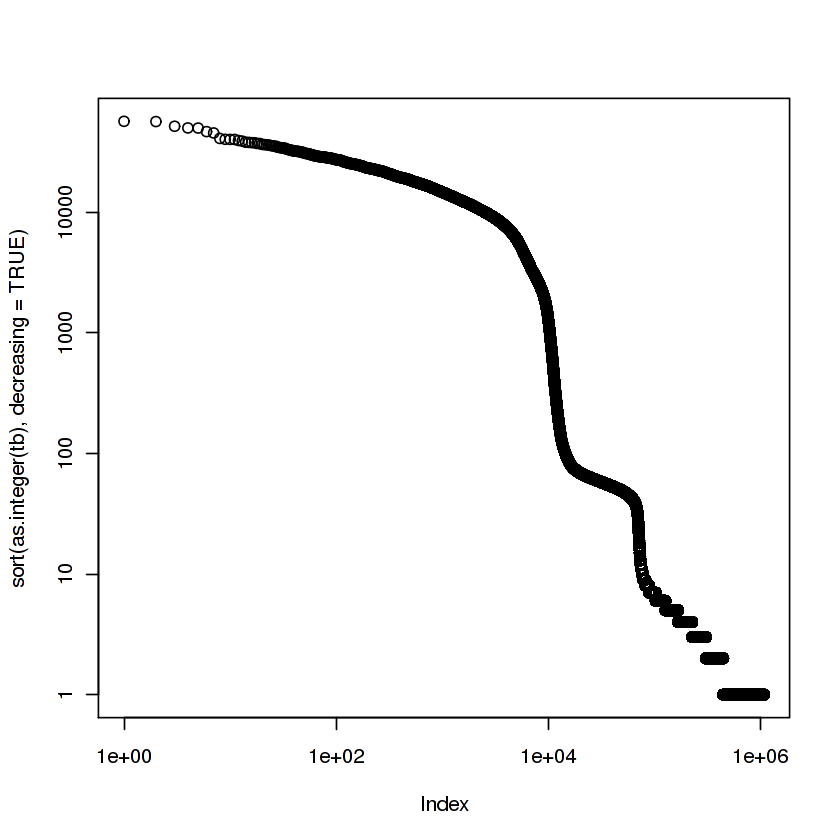

In [436]:
## Sorting and plotting the table recapitulates the graph in the summary.html file
plot(sort(as.integer(tb), decreasing = TRUE), log = 'xy')

In [439]:
## This is two variables. The first is a string identifier for the reference genome used
## The second variable appears to be the index into the barcode variable, mapping cells to barcodes
barcode_info <- h5read(molfile, '/barcode_info')
str(barcode_info)

List of 2
 $ genomes    : chr [1(1d)] "GRCh38"
 $ pass_filter: int [1:3, 1:11015] 454 0 0 610 0 0 708 0 0 1298 ...


[1] 3382587

In [371]:
## Same as first variable above
barcode_info.genomes <- h5read(molfile, '/barcode_info/genomes')
str(barcode_info.genomes)

 chr [1(1d)] "GRCh38"


In [372]:
## Same as second variable above
barcode_info.pass_filter <- h5read(molfile, '/barcode_info/pass_filter')
str(barcode_info.pass_filter)

 int [1:3, 1:11015] 454 0 0 610 0 0 708 0 0 1298 ...


In [373]:
## This is an index list of the barcodes that might map to cells. Most do not. Needed with the barcode info
barcodes <- h5read(molfile, '/barcodes')
str(barcodes)

 chr [1:6794880(1d)] "AAACCCAAGAAACACT" "AAACCCAAGAAACCAT" ...


In [404]:
## This is the read counts for each molecule.
count <- h5read(molfile, '/count')
str(count)
summary(count)

 int [1:80507484(1d)] 4 3 3 1 3 2 3 2 1 5 ...


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    1.00    2.00    2.52    3.00  293.00 

In [378]:
## This maps each UMI to a gene (feature)
feature_idx <- h5read(molfile, '/feature_idx')
str(feature_idx)

 int [1:80507484(1d)] 15169 1814 11451 12039 16780 29244 18002 31583 33496 31008 ...


In [382]:
## The feature_idx and be used to find out which gene the umi belongs with
features <- h5read(molfile, '/features')
str(features)

List of 5
 $ _all_tag_keys: chr [1(1d)] "genome"
 $ feature_type : chr [1:33538(1d)] "Gene Expression" "Gene Expression" "Gene Expression" "Gene Expression" ...
 $ genome       : chr [1:33538(1d)] "GRCh38" "GRCh38" "GRCh38" "GRCh38" ...
 $ id           : chr [1:33538(1d)] "ENSG00000243485" "ENSG00000237613" "ENSG00000186092" "ENSG00000238009" ...
 $ name         : chr [1:33538(1d)] "MIR1302-2HG" "FAM138A" "OR4F5" "AL627309.1" ...


In [4]:
help(Seurat)